In [2]:
import pandas as pd
import numpy as np
import pandasql as sqldf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
from sklearn.model_selection import train_test_split
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

#from ensemble import EnsembleRegressionFormula1

In [3]:
class EnsembleRegressionFormula1(object):
    
    def __init__(self, en_count = 7, batchsize = 0.3):
        #defining key informations for the ensemble
        self.__ensembles = []
        self.__batchsize = batchsize
        self.__train = {}
        self.__target = None
        self.__encodeattr = None
        self.weights = {}
        #datadimensionality BEFORE encoding
        self.__dimensions_b = {}
        #datadimensionality AFTER encoding
        self.__dimensions_a = {}
        
        #initializing the linear regression models
        self.__initialize_models(en_count)
        
    def __initialize_models(self, count):
        if isinstance(count, int) or isinstance(count,float):
            if count%2 == 0:
                count += 1
                print('to make a better prediction your count has been updated to an odd number')
            for x in range(count):
                model = LinearRegression()
                self.__ensembles.append(model)
        else:
            raise Exception('No valid input for number of models, use type float or int')
            
    def __PP(self, prediction_df):
        d = prediction_df.copy(deep = True)
        
        d.sort_values(by = '')
    
    def add_race(self, race, raceId = 0, shortened_columns = 0):
        '''
            race: Dictionary welches DataFrames mit Rennen enthält oder Dataframe für ein einzelnes Rennen
            raceId: wird nur benötigt wenn kein Dictionary übergeben wurde, ordnet dem einzelnen Rennen eine RennId zu
            shortened_columns: liste mit spaltennamen, die für die Daten behalten werden sollen, alle anderen werden
                            entfernt, wenn 0 übergeben wird werden alle Spalten verwendet
                            
            es kann entweder ein dictionary mit allen rennen (nach rennid zugeordnet)
            aufeinmal übergeben werden oder ein dataframe mit einem rennen nacheinander
            Hinweis: die target Variable sollte in den shortened columns NOCH ENTHALTEN SEIN!
        
            --> Target Variable nicht entfernen!
        '''
        if isinstance(race, dict):
            if shortened_columns == 0:
                self.__train = race
            else:
                for r in race.keys():
                    race[r] = race[r][shortened_columns]
                self.__train = race
        else:
            if shortened_columns == 0:
                self.__train[raceId] = race
            else:
                self.__train[raceId] = race[shortened_columns]
    
    def shuffle(self, c = 1):
        '''
            c: amount of times the datadictionary will be shuffled
        '''
        for i in range(c):
            keys = list(self.__train.keys())
            random.shuffle(keys)
            t = {}
            for key in keys:
                t[key] = self.__train[key]
            self.__train = t
            
    def predict(self, X):
        '''
            X: DataFrame with data on which prediction will be performed (one race at a time)
        '''
        if self.__target in list(X.columns):
            del X[self.__target]
            print('the target variable has been removed from the dataset')
            
        predictions = []
        m = 0
        for model in self.__ensembles:
            dimensions_b = self.__dimensions_b[m]
            dimensions_a = self.__dimensions_a[m]
            m += 1
            if dimensions_a['X'] == dimensions_b['X']:
                print('Note that you are working on data which has not been transformed in its dimensionality')
                if len(X.columns) != dimensions_a['X']:
                    print("Dimensionality of data doesn't fit the expected dimensions")
                    print('Note that model',m,'could not be used because of wrong dimensionality of the data')
                else:
                    
                    X_ = np.array(X)
                    A = model.predict(X_)
                    predictions.append(A)
            else:
                print('Note that your data will be hot encoded on the attributes:', self.__encodeattr)
                X_ = self.hot_encode_top(self.__encodeattr, X)
                X_ = np.array(X_)
                A = model.predict(X_)
                #M = m-1
                #w = self.weights[M]
                #A = A*w
                predictions.append(A)
        pred = np.empty(len(X))
        for prediction in predictions:
            p = np.array(prediction)
            pred = pred+p
        pred = pred/len(self.__ensembles)
        #pred = pred/np.sum(list(self.weights.values()))
        prediction = np.array(pred)
        return prediction
    
    def fit(self, target = 'total_milliseconds', method = 'mse',*encoding_attr):
        '''
            updating target variable of the models
            *encoding_attr is a list which contains attributes to encode (for categorical data)
        '''
        self.__target = target
        mses = {}
        if len(list(self.__train.keys())) == 0:
            raise Exception('Data needs to be transfered to the Ensemble before fitting!')
        else:
            es = []
            l = len(self.__train.keys())
            l = int(np.round(l*self.__batchsize))
            m = 0
            for model in self.__ensembles:
                X = pd.DataFrame()
                y = pd.Series()
                self.shuffle(3)
                batch = list(self.__train.keys())
                batch = batch[:l]
                for b in batch:
                    b_ = self.__train[b]
                    #removing target attribute from dataset if existing
                    columns = [x for x in b_.columns if x != target]
                    y_, X_ = b_[target], b_[columns]
                    y  = y.append(y_)
                    X = X.append(X_)
                dim = {}
                dim['X'] = X.shape[1]
                dim['y'] = X.shape[0]
                self.__dimensions_b[m] = dim
                #encoding given columns and saving dimensions
                self.__encodeattr = encoding_attr
                X = self.hot_encode_top(encoding_attr,X)
                dim = {}
                dim['X'] = X.shape[1]
                dim['y'] = X.shape[0]
                self.__dimensions_a[m] = dim
                m += 1
                X = np.array(X)
                y = np.array(y)
                model = model.fit(X,y)
                a = model.predict(X)
                #if method == 'mse':
                #    error = mean_squared_error(y,a)
                #    M = m-1
                #    if M in list(errors.keys()):
                #        errors[M] = errors[M]+error
                #    else:
                #        errors[M] = error
                #        
                #if method == 'mae':
                #    pass
                #if method == 'r2score':
                #    pass
                es.append(model)
            self.__ensembles = es
            #self.__initialize_weights(mses, method = method)
    
    def __initialize_weights(self, mse_dict, method = 'mse'):
        
        z = len(self.__ensembles)
        n = len(self.__ensembles)
        if method == 'mse' or method == 'mae':
            for x in range(len(mse_dict.keys())):
                weight = z/n
                z = z-1
                k = min(mse_dict, key=mse_dict.get)
                self.weights[k] = weight
                del mse_dict[k]
        elif method == 'r2score':
            for x in range(len(mse_dict.keys())):
                weight = z/n
                z = z-1
                k = max(mse_dict, key=mse_dict.get)
                self.weights[k] = weight
                del mse_dict[k]
    
    def hot_encode_top (self, column, df, feat_count = 10):
        '''
        hot one encoding, limitiert auf die feat_count häufigsten features
        eines nominalen features um zu Hohe dimensionen zu vermeiden
        
        column: liste mit einem oder mehr Spaltennamen, die hot encoded werden sollen
        df: dataframe der die Datenbasis darstellt
        feat_count: Anzahl Spalten die für jede Spalte encoded werden
        '''
        df_ = df.copy(deep = True)
        
        for col in column:
            
            
            #nur die häufigsten feat_count Featues werden encoded
            encode_features = [x for x in df_[col].value_counts(ascending = False).head(feat_count).index]
            if col == 'status_clean':
                #encode_features = ['lapped', 'Finished', 'DNF']
                encode_features = ['Finished', 'DNF']
            for feature in encode_features:
                col_feature = col + '_'+str(feature)
                
                #dort wo feature nicht dem encode feature entspricht wird eine 0 gesetzt
                df_[col_feature] = df_.where(df_[col] == feature, other = 0)[col]
                #encode feature selbst wird in dataframe durch eine 1 ersetzt
                df_[col_feature].replace(feature, 1, inplace = True)
                
            
            #löschen der nun "bereinigten" Spalte
            del df_[col]
            
        return df_
    
    def optimize_weights(self,y,A):
        '''
            y: target output (vektor)
            A: predicted Output (list of vektors)
        '''
        A = [np.array(v) for v in A]
        #x = self.weights
        weights = [self.weights[i] for i in range(len(self.__ensembles))]
        weights = np.array(weights)
        
        x = 0
        i=0
        for v in A:
            x = x +(v*weights[i])
        def f(x):
            return mean_squared_error(y, x)
        
    def infos(self):
        print('Anzahl ensembles:', len(self.__ensembles))
        print('Länge des Train dictionarys:', len(list(self.__train.keys())))
        print('Batchsize:', self.__batchsize)
        print('Set Targetvariable:', self.__target)
        print('Encoding Attributes:', self.__encodeattr)
        print('Dimensions of Models before encoding:', self.__dimensions_b)
        print('Dimensions of Models after encoding:', self.__dimensions_a)
        

In [4]:
rain_id = [847,861,879,910,914,934,942,953,957,967,970,982]
if os.path.exists('sliced_data70'):
    csv_filenames = []
    #auslesen aller csv file dateinamen aus formula 1 datensatz und abspeichern in liste
    for filename in os.listdir(os.getcwd()+'/sliced_data70'):
        typ = filename.split('.')[-1]
        name = filename.split('.')[0]
        if typ == 'csv':
            csv_filenames.append(filename)
    sliced_races = {}
    #einlesen und abspeichern als dataframe aller dateien
    for file in csv_filenames:
        try:
            df = pd.read_csv('sliced_data70/'+file, engine = 'python', sep = ';', decimal = '.')
            del df['Unnamed: 0']
        except Exception as e:
            df = pd.read_csv('sliced_data70/'+file, engine = 'c', sep = ';', decimal = '.')
            del df['Unnamed: 0']
            print(e)
        #print(df.head())
        f = int(file.split('_')[-1].split('.')[0])
        df["rain"] = 0
        if list(df["raceId"])[0] in rain_id:
            df["rain"] = 1
        sliced_races[f] = df
    print('Einlesen der sliced Dateien erfolgreich')
else:
    print('Dateien können nicht eingelesen werden, da kein entsprechendes Verzeichnis existiert!')
    
if os.path.exists('split_data'):
    csv_filenames = []
    #auslesen aller csv file dateinamen aus formula 1 datensatz und abspeichern in liste
    for filename in os.listdir(os.getcwd()+'/split_data'):
        typ = filename.split('.')[-1]
        name = filename.split('.')[0]
        if typ == 'csv':
            csv_filenames.append(filename)
    split_by_race = {}
    #einlesen und abspeichern als dataframe aller dateien
    for file in csv_filenames:
        try:
            df = pd.read_csv('split_data/'+file, engine = 'python', sep = ';', decimal = '.')
            del df['Unnamed: 0']
        except Exception as e:
            df = pd.read_csv('split_data/'+file, engine = 'c', sep = ';', decimal = '.')
            del df['Unnamed: 0']
            print(e)
        #print(df.head())
        f = int(file.split('_')[-1].split('.')[0])
        split_by_race[f] = df
    print('Einlesen der split Dateien erfolgreich')
else:
    print('Dateien können nicht eingelesen werden, da kein entsprechendes Verzeichnis existiert!')

Einlesen der sliced Dateien erfolgreich
Einlesen der split Dateien erfolgreich


In [5]:
def get_position(prediction, col = 'prediction'):
    #deep copy von dataframe mit spalte col
    d = prediction.copy(deep = True)
    #erzeugen der neuen spalte pred_position und befüllen mit 0en
    d['pred_position'] = 0
    
    #schreiben aller predicteten werte in eine liste
    preds = d[col].tolist()
    #setzen der position p (1 weil beste position)
    p = 1
    #für jede zeile im übergebenen dataframe wird die position anhand der prediction bestimmt
    for i in range(len(d[col])):
        #kleinste zeit wird aus liste genommen und anschließend gelöscht
        b = min(preds)
        preds.remove(b)
        #finden der richtigen zeile im df und schreiben der position an diese stelle
        idx = d.where(d[col] == b).dropna(how = 'all').index
        d.loc[idx,'pred_position'] = p
        p+=1 #position wird eins hochgezählt
        
    return d

In [7]:
ens = EnsembleRegressionFormula1(9)
nogo_columns = [#'grid',
                #'race_completion',
                'lap_position','circuitId','lap_number',
                'podium_position', 'raceId',
                'grandprix_name', 'driver_fullname',
               'constructor_name', 'total_laps',
               'status_clean', 'constructorId',
                'total_milliseconds', 
                #'driverId',
               'lap_in_milliseconds','year', 'stop_binary']

keys = list(sliced_races.keys())
random.shuffle(keys)
sliced_shuffled = {}
for key in keys:
    sliced_shuffled[key] = sliced_races[key]

target_ = 'total_minutes'
train_break = 120
category_count = 13
counter = 0

print('---training---')
t = {}
for key, value in sliced_shuffled.items():
    if counter != train_break:
        d_ = value.copy(deep = True)
        d_['total_minutes'] = d_['total_milliseconds'] / 60000
        t[key] = d_
        counter += 1
        
cols = [col for col in d_.columns if col not in nogo_columns]
#addig dictionary with datasets to ensemble
ens.add_race(t, 0,cols)
#setting target_variable for fit to total_milliseconds and giving attributes to encode (driverId)
ens.fit(target_, 'driverId')
#getting general information about the created ensemble
ens.infos()
mses = {}
for id, race in t.items():
    r_ = race.copy(deep = True)
    print(r_.columns)
    
    y = race[target_]
    p = ens.predict(r_)
    r_['prediction'] = p
    sol = get_position(r_,'prediction')
    print(sol)
    break
    mse = mean_squared_error(y,p)
    mses[id] = mse

---training---
Anzahl ensembles: 9
Länge des Train dictionarys: 120
Batchsize: 0.3
Set Targetvariable: total_minutes
Encoding Attributes: ()
Dimensions of Models before encoding: {0: {'X': 6, 'y': 29596}, 1: {'X': 6, 'y': 29884}, 2: {'X': 6, 'y': 30506}, 3: {'X': 6, 'y': 31585}, 4: {'X': 6, 'y': 29637}, 5: {'X': 6, 'y': 28964}, 6: {'X': 6, 'y': 29880}, 7: {'X': 6, 'y': 29172}, 8: {'X': 6, 'y': 31196}}
Dimensions of Models after encoding: {0: {'X': 6, 'y': 29596}, 1: {'X': 6, 'y': 29884}, 2: {'X': 6, 'y': 30506}, 3: {'X': 6, 'y': 31585}, 4: {'X': 6, 'y': 29637}, 5: {'X': 6, 'y': 28964}, 6: {'X': 6, 'y': 29880}, 7: {'X': 6, 'y': 29172}, 8: {'X': 6, 'y': 31196}}
Index(['driverId', 'race_completion', 'grid', 'form',
       'sum_milliseconds_pro_lap', 'rain', 'total_minutes'],
      dtype='object')
the target variable has been removed from the dataset
Note that you are working on data which has not been transformed in its dimensionality
Note that you are working on data which has not been t

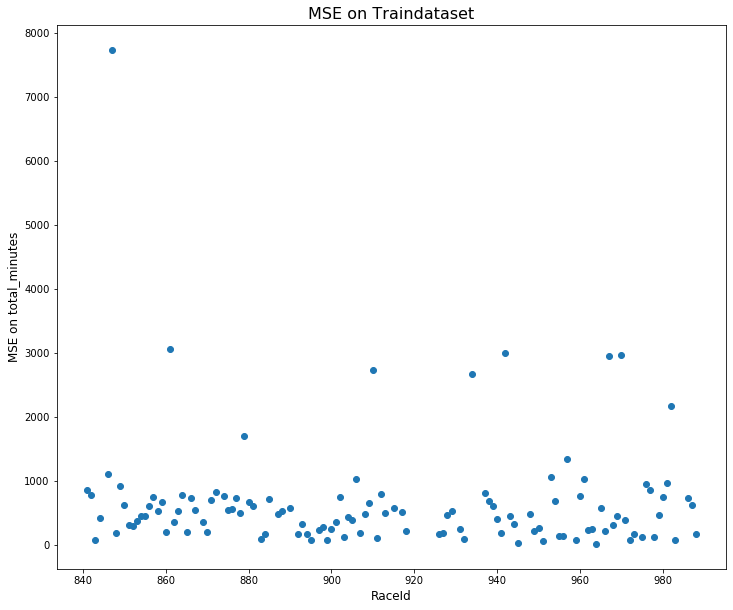

In [101]:
x,y = list(mses.keys()),list(mses.values())

fig = plt.figure(figsize = (12,10))
plt.plot(x,y,'o')
plt.title('MSE on Traindataset', fontsize=16)
plt.xlabel('RaceId', fontsize=12)
mse_text = 'MSE on '+ target_
plt.ylabel(mse_text, fontsize=12);

In [102]:
print('mean mse', np.mean(y))
print('min mse:', min(y))
print('max mse:', max(y))

mean mse 658.1266014393739
min mse: 7.698186865455293
max mse: 7732.864364891695


In [103]:
ens.weights

{7: 1.0,
 6: 0.8888888888888888,
 1: 0.7777777777777778,
 5: 0.6666666666666666,
 0: 0.5555555555555556,
 8: 0.4444444444444444,
 2: 0.3333333333333333,
 3: 0.2222222222222222,
 4: 0.1111111111111111}

In [104]:
print('---testing---')
te = {}
mses_test = {}
for key, value in sliced_shuffled.items():
    if key not in list(t.keys()):
        d_ = value.copy(deep = True)
        d_['total_minutes'] = d_['total_milliseconds'] / 60000
        te[key] = d_
        y = d_[target_]
        r_ = d_[cols]
        p = ens.predict(r_)
        mse = mean_squared_error(y,p)
        mses_test[id] = mse

---testing---
the target variable has been removed from the dataset
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
the target variable has been removed from the dataset
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
No

Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
the target variable has been removed from the dataset
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
Note that your data will be hot encoded on the attributes: ('driverId',)
the target variable has been removed from the dataset
Note that your d

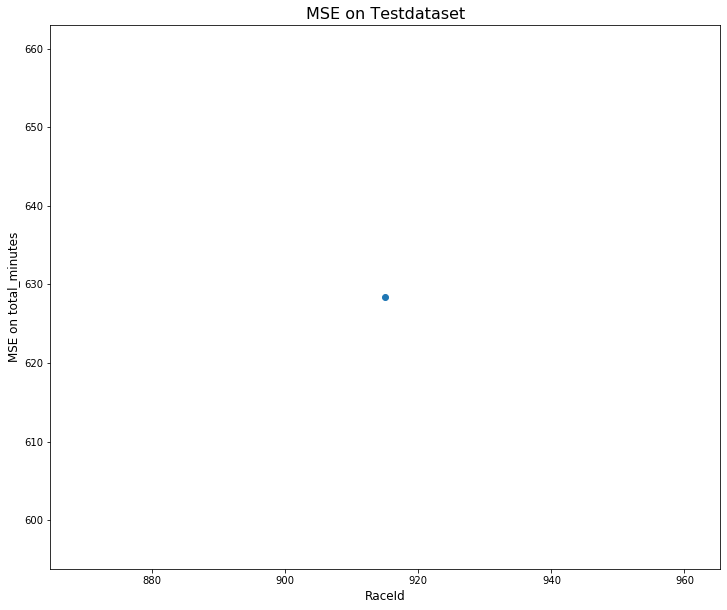

In [105]:
x,y = list(mses_test.keys()),list(mses_test.values())

fig = plt.figure(figsize = (12,10))
plt.plot(x,y,'o')
plt.title('MSE on Testdataset', fontsize=16)
plt.xlabel('RaceId', fontsize=12)
mse_text = 'MSE on '+ target_
plt.ylabel(mse_text, fontsize=12);

In [106]:
print('mean mse', np.mean(y))
print('min mse:', min(y))
print('max mse:', max(y))

mean mse 628.4089504602412
min mse: 628.4089504602412
max mse: 628.4089504602412
